This follows the tutorial from https://www.oreilly.com/learning/generative-adversarial-networks-for-beginners

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from tensorflow.examples.tutorials.mnist import input_data

In [4]:
mnist = input_data.read_data_sets('mnist/')

Extracting mnist/train-images-idx3-ubyte.gz
Extracting mnist/train-labels-idx1-ubyte.gz
Extracting mnist/t10k-images-idx3-ubyte.gz
Extracting mnist/t10k-labels-idx1-ubyte.gz


In [5]:
X_train_b, Y_train_b = mnist.train.next_batch(25)

## Helpers

In [8]:
def conv_layer(X, num_filters, num_input_channels, layer_num):
    """Creates and returns a convolutional layer by applying a 5x5 convolution, relu, then 2x2 max pooling"""
    w = tf.get_variable('d_w%d' % layer_num, [5, 5, num_input_channels, num_filters],
                        initializer = tf.truncated_normal_initializer(stddev=0.2))
    b = tf.get_variable('d_b%d' % layer_num, [num_filters], initializer = tf.constant_initializer(0))
    d = tf.nn.conv2d(X, w, strides=[1,1,1,1], padding='SAME') + b
    d = tf.nn.elu(d)
    d = tf.nn.avg_pool(d, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    return d

In [9]:
def fcl(X, input_size, num_neurons, layer_num):
    """Applies a fully connected layer, without the activation function"""
    w = tf.get_variable('d_w%d' % layer_num, [input_size, num_neurons], 
                           initializer=tf.truncated_normal_initializer(stddev=0.02))
    b = tf.get_variable('d_b%d' % layer_num, [num_neurons], initializer=tf.constant_initializer(0))
    d = tf.matmul(X, w) + b
    return d

## Discriminator / Generator

In [10]:
def discriminator(X, reuse=False):
    """TODO: Batch Norm or Local Response Normalization, because relu is unbounded"""
    if reuse:
        tf.get_variable_scope().reuse_variables()
    
    # 32 filters of 5x5 (shape = (?, 14, 14, 32)). Then 64 filters of 5x5 (shape = (?, 7, 7, 64))
    c0 = conv_layer(X, num_filters=32, num_input_channels=1, layer_num=0)
    c1 = conv_layer(c0, num_filters=64, num_input_channels=32, layer_num=1)
    
    # resizes to [batch_size, dim]
    c1 = tf.reshape(c1, [-1, 7*7*64])
    fc_0 = tf.nn.elu(fcl(c1, 7*7 *64, num_neurons=1024, layer_num=2))
    # TODO: why don't we sigmoid the last layer?
    fc_1 = fcl(fc_0, 1024, num_neurons=1, layer_num=3)
    
    return fc_1


In [14]:
def generator(U):
    """"""
    batch_size, dims = U.shape[0], U.shape[1]
    g_w0 = tf.get_variable('g_w0', [dims, 56*56], dtype=tf.float32, 
                           initializer=tf.truncated_normal_initializer(stddev=0.2))
    g_b0 = tf.get_variable('g_b0', [56*56], dtype=tf.float32, initializer=tf.constant_initializer(0))
    g0 = tf.matmul(U, g_w0) + g_b0
    g0 = tf.reshape(g0, [-1, 56, 56, 1])
    g0 = tf.nn.elu(g0)
    g0 = tf.contrib.layers.batch_norm(g0, epsilon=1e-5)
    
    # Generate 50 features using 3x3 convolution on the 56x56 image
    g_w1 = tf.get_variable('g_w1', [3, 3, 1, 50], dtype=tf.float32, 
                           initializer=tf.truncated_normal_initializer(stddev=0.2))
    g_b1 = tf.get_variable('g_b1', [50], dtype=tf.float32, initializer=tf.constant_initializer(0))
    g1 = tf.nn.conv2d(g0, g_w1, strides=[1,2,2,1], padding='SAME')
    g1 = g1 + g_b1
    g1 = tf.nn.elu(g1)  
    # g1.shape -> (?, 28, 28, 50)
    g1 = tf.contrib.layers.batch_norm(g1, epsilon=1e-5) 
    g1 = tf.nn.dropout(g1, 0.5)
    # uses bilinear interpolation to resize 28x28 -> 56x56
    g1 = tf.image.resize_images(g1, [56, 56])
    
    # Generate 25 features using 3x3 convolution on the 56x56 image
    g_w2 = tf.get_variable('g_w2', [3, 3, 50, 25], dtype=tf.float32, 
                           initializer=tf.truncated_normal_initializer(stddev=0.2))
    g_b2 = tf.get_variable('g_b2', [25], dtype=tf.float32, initializer=tf.constant_initializer(0))
    g2 = tf.nn.conv2d(g1, g_w2, strides=[1,2,2,1], padding='SAME')
    g2 = g2 + g_b2
    g2 = tf.nn.elu(g2)  
    # g1.shape -> (1, 28, 28, 50)
    g2 = tf.contrib.layers.batch_norm(g2, epsilon=1e-5) 
    g2 = tf.nn.dropout(g2, 0.5)
    # uses bilinear interpolation to resize 28x28 -> 56x56
    g2 = tf.image.resize_images(g2, [56, 56])
    
    # Final convolution with 1 output channel
    g_w3 = tf.get_variable('g_w3', [1, 1, 25, 1], dtype=tf.float32, 
                           initializer=tf.truncated_normal_initializer(stddev=0.2))
    g_b3 = tf.get_variable('g_b3', [1], dtype=tf.float32, initializer=tf.constant_initializer(0))
    g3 = tf.nn.conv2d(g2, g_w3, strides=[1,2,2,1], padding='SAME')
    g3 = g3 + g_b3
    g3 = tf.sigmoid(g3)
    
    return g3

## Computation Graph

In [15]:
tf.reset_default_graph()
U_placeholder = tf.placeholder(tf.float32, [None, 100])
X_placeholder = tf.placeholder(tf.float32, [None, 28, 28, 1])

with tf.variable_scope('gen_dis_scope'):
    Gu = generator(U_placeholder)
    Dx = discriminator(X_placeholder, reuse=False)
    # reuse same variables as Dx discriminator
    Dg = discriminator(Gu, reuse=True)

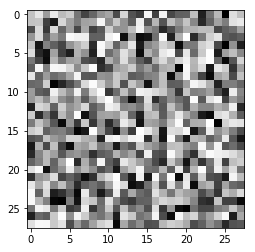

In [17]:
# Lets view a generated image...
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    U = np.random.normal(0, 1, [1, 100])
    gen_img = sess.run(Gu, feed_dict = {U_placeholder: U})
    gen_img = gen_img.reshape([28, 28])
    plt.imshow(gen_img, cmap='Greys')

In [18]:
# Loss functions
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dx, labels=tf.ones_like(Dx)))
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dg, labels=tf.zeros_like(Dg)))
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dg, labels=tf.ones_like(Dg)))

In [19]:
# Optimizers
trainable_vars = tf.trainable_variables()
d_vars = [var for var in trainable_vars if 'd_' in var.name]
g_vars = [var for var in trainable_vars if 'g_' in var.name]

print [var.name for var in d_vars]
print [var.name for var in g_vars]

# be careful, AdamOptimizer creates its own vars for memory, and could play poorly with reuse 
# (https://stackoverflow.com/questions/42603702/variable-scope-causes-variable-does-not-exist-with-optimizer)
d_optimizer = tf.train.AdamOptimizer(0.0003).minimize(d_loss_real + d_loss_fake, var_list=d_vars)
g_optimizer = tf.train.AdamOptimizer(0.0001).minimize(g_loss, var_list=g_vars)

[u'gen_dis_scope/d_w0:0', u'gen_dis_scope/d_b0:0', u'gen_dis_scope/d_w1:0', u'gen_dis_scope/d_b1:0', u'gen_dis_scope/d_w2:0', u'gen_dis_scope/d_b2:0', u'gen_dis_scope/d_w3:0', u'gen_dis_scope/d_b3:0']
[u'gen_dis_scope/g_w0:0', u'gen_dis_scope/g_b0:0', u'gen_dis_scope/g_w1:0', u'gen_dis_scope/g_b1:0', u'gen_dis_scope/g_w2:0', u'gen_dis_scope/g_b2:0', u'gen_dis_scope/g_w3:0', u'gen_dis_scope/g_b3:0']


## Prep for Tensorboard

In [20]:
# From this point forward, reuse variables
import datetime
tf.get_variable_scope().reuse_variables()

tf.summary.scalar('Generator_loss', g_loss)
tf.summary.scalar('Discriminator_loss_real', d_loss_real)
tf.summary.scalar('Discriminator_loss_fake', d_loss_fake)
with tf.variable_scope('gen_dis_scope'):
    images_for_tensorboard = generator(U_placeholder)
tf.summary.image('Generated_images', images_for_tensorboard, 5)
merged = tf.summary.merge_all()
logdir = "tensorboard/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "/"
writer = tf.summary.FileWriter(logdir, sess.graph)

In [25]:
def get_model_filepath(model_dir):
    """Returns (the most recent model filepath, step_count)"""
    import os
    model_nums = {int(f.split('.')[0].split('-')[-1]) for f in os.listdir(model_dir) if f.startswith('model-')}
    if model_nums:
        while model_dir[-1] == '/':
            model_dir = model_dir[:-1]
        return '%s/model-%d' % (model_dir, max(model_nums)), max(model_nums)
!ls models
print get_model_filepath('./models/926c8ca')

926c8ca curr
('./models/926c8ca/model-1499', 1499)


## Train!

INFO:tensorflow:Restoring parameters from ./models/curr/model-999


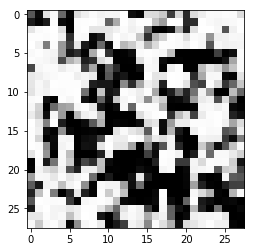

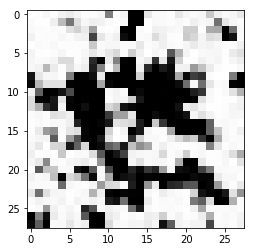

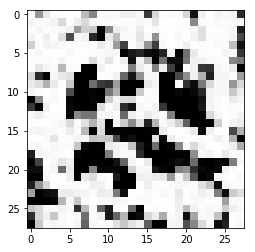

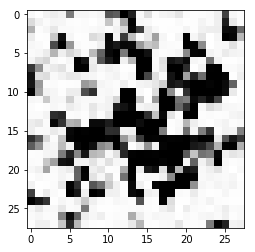

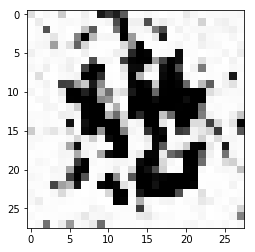

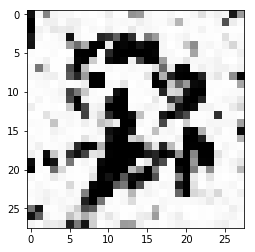

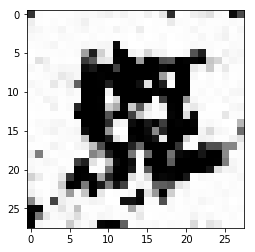

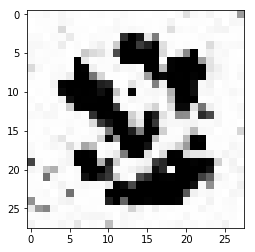

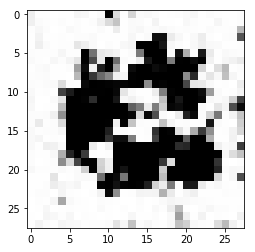

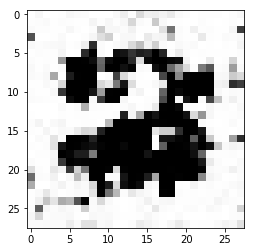

In [27]:
batch_size = 50
model_dir = './models/curr'
use_model_filepath = True
step = 0
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    if use_model_filepath:
        model_filepath, step = get_model_filepath(model_dir)
        saver.restore(sess, model_filepath)
    for i in range(step, step+1000):
        train_batch = mnist.train.next_batch(batch_size)
        x_train_batch = train_batch[0].reshape([-1,28,28,1])
        u_batch = np.random.normal(0, 1, [batch_size, 100])
        # train discriminator
        if i >= 0:
            _, d_loss_real_val, d_loss_fake_val = sess.run([d_optimizer, d_loss_real, d_loss_fake], 
                                                               feed_dict={X_placeholder: x_train_batch, U_placeholder: u_batch})
        # train generator
        if i >= 300:
            u_batch = np.random.normal(0, 1, [batch_size, 100])
            _, g_loss_val = sess.run([g_optimizer, g_loss], feed_dict={U_placeholder: u_batch})
        # Update tensorboard
        if i % 10 == 0:
            u_batch = np.random.normal(0, 1, [batch_size, 100])
            summary = sess.run(merged, feed_dict={X_placeholder: x_train_batch, U_placeholder: u_batch})
            writer.add_summary(summary, i)
        if i % 100 == 0:
            u_batch = np.random.normal(0, 1, [batch_size, 100])
            img = sess.run(Gu, feed_dict={U_placeholder: u_batch})
            plt.imshow(img[0].reshape([28,28]), cmap='Greys')
            plt.show()
        # Save model to disk
        if (i+1) % 500 == 0:
            saver.save(sess, '%s/model' % model_dir, global_step=i)